# richman non-stationarity score (上級チュートリアル)

このチュートリアルでは、筆者が考案したrichman non-stationarity scoreを紹介します。
特徴量選択に使えます。

## 準備

df_features.pklは、https://github.com/richmanbtc/mlbot_tutorial/blob/master/work/tutorial.ipynb を実行して作ってください。

以下では、richman non-stationarity scoreを使い、特徴量の非定常性を測っています。
richman non-stationarity scoreはrichmanbtcが考案した非定常性の度合いを測る指標です。

特徴量の定常性の度合いが低いと、汎化性能が悪化する可能性があるので、
scoreが低くなるように特徴量エンジニアリングを行います。
0.3以下が目安です。

## 特徴量分布の定常性の度合いが低いと汎化性能が悪化する理由

特徴量分布が定常だと、未来でも同じ分布になることが期待できます。
一方、定常でないと、時刻によって特徴量分布が変わるので、
未来の特徴量分布が学習データの特徴量分布と異なる可能性があります。
その場合、学習データに無いデータを予測することになるので、
性能が劣化する可能性があります。

## richman non-stationarity scoreの計算方法

計算に必要なパラメータ: 回帰モデル、CVのfold数

1. シャッフル付きKFold CVで以下の2, 3を計算し、R2の平均をrichman non-stationarity scoreとする
2. 特徴量からサンプルインデックス(時刻でも良い)を与えられた回帰モデルで学習
3. validationデータに対して、サンプルインデックスを予測し、予測精度をR2で評価

この例では回帰モデルはデフォルトパラメータのlgbm、CVのfolds数は2を選んでいます。

## richman non-stationarity scoreの特徴量重要度

ツリー系モデルを使うと、重要度を表示できるので便利です。
重要度の高いものが定常性を劣化させていることがわかります。

## 参考リンク

- [時系列予測での特徴量選択](https://note.com/btcml/n/na4376bc5c336)
- [Kaggleで役立つAdversarial Validationとは](https://www.acceluniverse.com/blog/developers/2020/01/kaggleadversarial-validation.html)


In [3]:
import math

import ccxt
from crypto_data_fetcher.bybit import BybitFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [4]:
features = sorted([

#    'ADX',
#    'ADXR',
#    'APO',
#    'AROON_aroondown',
#    'AROON_aroonup',
#    'AROONOSC',
#    'CCI',
#    'DX',
#    'MACD_macd',
#    'MACD_macdsignal',
#    'MACD_macdhist',
#    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
#    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
#    'RSI',
#    'STOCH_slowk',
#    'STOCH_slowd',
#    'STOCHF_fastk',
#     'STOCHRSI_fastd',
#    'ULTOSC',
#    'WILLR',
#     'ADOSC',
#     'NATR',
#    'HT_DCPERIOD',
#    'HT_DCPHASE',
#    'HT_PHASOR_inphase',
#    'HT_PHASOR_quadrature',
#    'HT_TRENDMODE',
#    'BETA',
#    'LINEARREG',
#    'LINEARREG_ANGLE',
#    'LINEARREG_INTERCEPT',
#    'LINEARREG_SLOPE',
#    'STDDEV',
#    'BBANDS_upperband',
#    'BBANDS_middleband',
#    'BBANDS_lowerband',
#    'DEMA',
    'EMA1',
    'EMA2',
    'EMA3',
    'EMA4',
    'EMA5',
#    'HT_TRENDLINE',
#    'KAMA',
#    'MA',
#    'MIDPOINT',
#    'T3',
#    'TEMA',
#    'TRIMA',
#    'WMA',
])

print(features)

['EMA1', 'EMA2', 'EMA3', 'EMA4', 'EMA5']


dfは特徴量が入ったDataFrame
featuresは使う特徴量カラム名配列
重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある


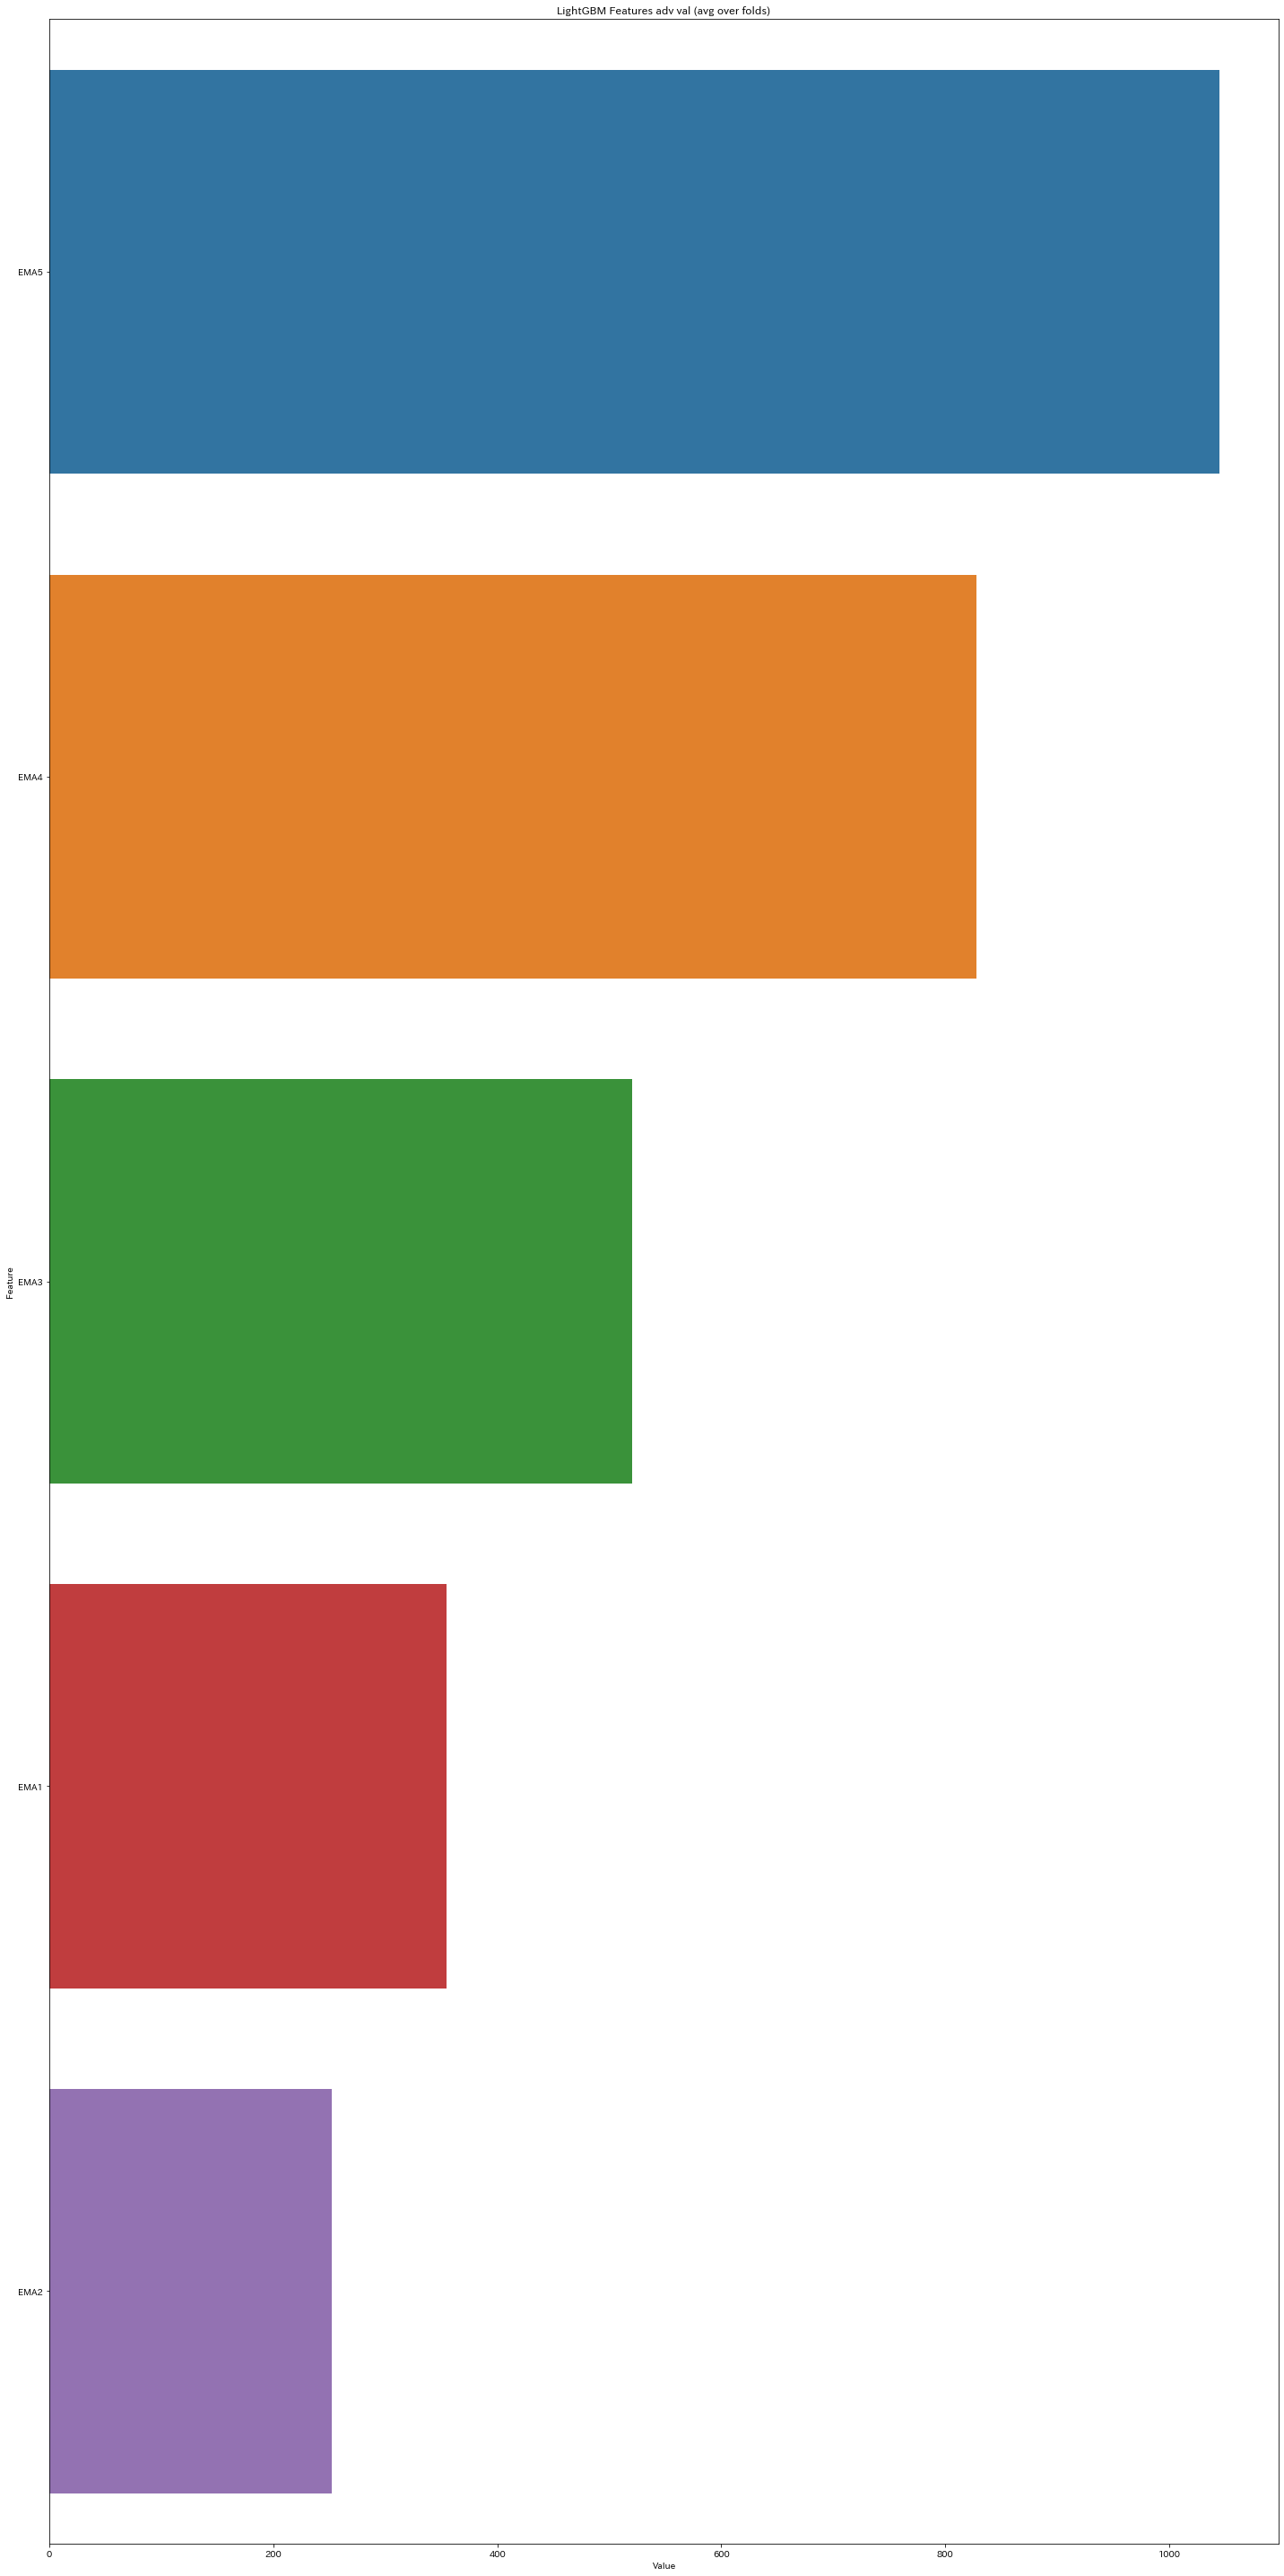

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.72513749 0.7233111 ]
score mean, std 0.7242242937802241 0.0009131933100320899


In [5]:
df = pd.read_pickle('df_bybit_features.pkl')

print('dfは特徴量が入ったDataFrame')
print('featuresは使う特徴量カラム名配列')

print('重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある')
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
model.fit(df[features], np.arange(df.shape[0]))
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))